## Руководство по сравнению моделей в bosk

Вы можете сравнивать разные модели в `bosk`: например, несколько Глубоких лесов `bosk` с разным количеством слоев и некоторые модели, созданные вне фреймворка. Для этого был разработан подпакет bosk.сomparison.


Для выполнения этого примера у Вас должен быть установлен `Pytorch`. Если у вас не установлен `torch` пакет в `Python`, выполните следующую секцию:

In [ ]:
!pip install torch

Давайте определим несколько моделей:

In [1]:
from bosk.block.zoo.models.classification import RFCBlock
from bosk.comparison.cross_val import CVComparator
from bosk.comparison.base import BaseForeignModel
from bosk.comparison.metric import MetricWrapper
from bosk.data import CPUData, BaseData
from bosk.executor.topological import TopologicalExecutor
from bosk.painter.graphviz import GraphvizPainter
from bosk.painter.topological import TopologicalPainter
from bosk.pipeline.builder.functional import FunctionalPipelineBuilder
from bosk.stages import Stage
from catboost import CatBoostClassifier
from sklearn.datasets import make_moons
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import KFold
import numpy as np
import torch
from typing import Dict
from torch.utils.data import TensorDataset, DataLoader
from joblib import hash
from IPython.display import Image

In [2]:
n_trees = 20

# создадим несколько похожих конвейеров

b = FunctionalPipelineBuilder()
X, y = b.Input()(), b.TargetInput()()
rf_1 = b.RFC(n_estimators=n_trees)(X=X, y=y)
et_1 = b.ETC(n_estimators=n_trees)(X=X, y=y)
concat_1 = b.Concat(['X', 'rf_1', 'et_1'])(X=X, rf_1=rf_1, et_1=et_1)
rf_2 = b.RFC(n_estimators=n_trees)(X=concat_1, y=y)
pipeline_1 = b.build({'X': X, 'y': y}, {'output': rf_2})

b = FunctionalPipelineBuilder()
X, y = b.Input()(), b.TargetInput()()
rf_1 = b.RFC(n_estimators=n_trees)(X=X, y=y)
et_1 = b.ETC(n_estimators=n_trees)(X=X, y=y)
concat_1 = b.Concat(['X', 'rf_1', 'et_1'])(X=X, rf_1=rf_1, et_1=et_1)
rf_2 = b.RFC(n_estimators=n_trees)(X=concat_1, y=y)
stack = b.Stack(['rf_2_1', 'rf_2_2'], axis=2)(rf_2_1=rf_2, rf_2_2=rf_2)
av = b.Average(axis=2)(X=stack)
pipeline_2 = b.build({'X': X, 'y': y}, {'output': av})

b = FunctionalPipelineBuilder()
X, y = b.Input()(), b.TargetInput()()
rf_1 = b.RFC(n_estimators=n_trees)(X=X, y=y)
et_1 = b.ETC(n_estimators=n_trees)(X=X, y=y)
concat_1 = b.Concat(['X', 'rf_1', 'et_1'])(X=X, rf_1=rf_1, et_1=et_1)
rf_2 = b.RFC(n_estimators=n_trees)(X=concat_1, y=y)
et_2 = b.ETC(n_estimators=n_trees)(X=concat_1, y=y)
concat_2 = b.Concat(['rf_2', 'et_2', 'X'])(X=X, rf_2=rf_2, et_2=et_2)
et_3 = b.ETC(n_estimators=n_trees)(X=concat_2, y=y)
pipeline_3 = b.build({'X': X, 'y': y}, {'output': et_3})

pipeline_list = [pipeline_1, pipeline_2, pipeline_3]

Чтобы использовать модели, написанные вне bosk, вам нужно написать свой собственный класс адаптера, который наследует интерфейс `BaseForeignModel`. Этот интерфейс требует, чтобы модель обрабатывала словари данных bosk и реализовывала метод `set_random_state`, поскольку эксперимент по сравнению должен быть воспроизводимым.

Определим две такие модели:

In [3]:
class CatBoostModel(BaseForeignModel):
    def __init__(self) -> None:
        super().__init__()
        self.grad_boost = CatBoostClassifier(30, verbose=0)

    def fit(self, data: Dict[str, BaseData]) -> None:
        self.grad_boost.fit(
            data['X'].to_cpu().data,
            data['y'].to_cpu().data
        )

    def predict(self, data: Dict[str, BaseData]) -> Dict[str, BaseData]:
        return {'output': CPUData(
                self.grad_boost.predict_proba(data['X'].to_cpu().data)
                )}

    def set_random_state(self, random_state: int) -> None:
        self.grad_boost.random_state = random_state


class NeuralNetwork(torch.nn.Module):
    def __init__(self, dim: int) -> None:
        super().__init__()
        self.device = torch.device('cuda')
        self.nn = torch.nn.Sequential(
            torch.nn.Linear(dim, dim * 10),
            torch.nn.ReLU(),
            torch.nn.Linear(dim * 10, dim),
            torch.nn.Tanh(),
            torch.nn.Linear(dim, 1),
            torch.nn.Sigmoid()
        ).to(self.device)
        self.optimizer = torch.optim.Adam(self.nn.parameters(), 0.0005)
        self.batch_size = 64
        self.epochs_num = 500
        self.loss_fn = torch.nn.CrossEntropyLoss()

    def _get_tensor(self, x: np.ndarray) -> torch.Tensor:
        return torch.from_numpy(x.astype(np.float32)).to(self.device)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        proba = self.nn(x)
        return torch.concat((1 - proba, proba), dim=-1)

    def transform(self, x: np.ndarray) -> np.ndarray:
        with torch.no_grad():
            x = self._get_tensor(x)
            return self(x).cpu().numpy()

    def fit(self, x: np.ndarray, y: np.ndarray) -> 'NeuralNetwork':
        x_tens = self._get_tensor(x)
        y_tens = self._get_tensor(y).long()
        dataset = TensorDataset(x_tens, y_tens)
        data_loader = DataLoader(dataset, self.batch_size, True)
        self.train()
        for _ in range(self.epochs_num):
            for x, y in data_loader:
                self.optimizer.zero_grad()
                pred = self(x)
                loss = self.loss_fn(pred, y)
                loss.backward()
                self.optimizer.step()
        return self


class NNModel(BaseForeignModel):
    def __init__(self, dim: int) -> None:
        super().__init__()
        self.nn = NeuralNetwork(dim)

    def fit(self, data: Dict[str, BaseData]) -> None:
        return self.nn.fit(
            data['X'].to_cpu().data,
            data['y'].to_cpu().data
        )

    def predict(self, data: Dict[str, BaseData]) -> Dict[str, BaseData]:
        return {'output': CPUData(
                self.nn.transform(data['X'].to_cpu().data)
                )}

    def set_random_state(self, random_state: int) -> None:
        torch.manual_seed(random_state)

        def init_weights(obj):
            if isinstance(obj, torch.nn.Linear):
                torch.nn.init.xavier_uniform_(obj.weight)
        with torch.no_grad():
            self.nn.apply(init_weights)

Также нам нужно немного переопределить метрики sklearn и, как и выше, создать адаптеры для обработки словарей данных bosk (в этом примере мы сделаем это позже). К счастью, в случае простых метрик мы можем использовать готовый класс-оболочку `MetricWrapper`.

In [4]:
def accuracy(y_true, y_pred):
    return accuracy_score(y_true, np.int_(y_pred[:, 1]))


def roc_auc(y_true, y_pred):
    return roc_auc_score(y_true, np.int_(y_pred[:, 1]))

Теперь мы можем поговорить о классе `CVComparator`. Он выполняет сравнение различных моделей с помощью алгоритма перекрестной проверки. Схема перекрестной проверки выбирается пользователем и должна иметь интерфейс sklearn `BaseCrossValidator`.

Компаратор попытается оптимизировать переданные конвейеры `bosk`. Это означает, что компаратор попытается найти общую часть всех конвейеров и запустить эту часть только один раз. Это сократит время сравнения. Важная деталь: общие блоки находятся с помощью функции joblib.hash, и она может выдавать разные md5-хеши для семантически идентичных блоков:

In [5]:
block_1 = RFCBlock() # 100 деревьев по умолчанию
block_2 = RFCBlock(n_estimators=100) # точно так же 100 деревьев
# Хеши блоков будут разными
print('- Одинаковы ли хеши?')
print('-', hash(block_1) == hash(block_2))

- Одинаковы ли хеши?
- False


Поэтому перед сравнением для всех блоков конвейера устанавливается одно и то же случайное начальное число. Если по какой-то причине алгоритм оптимизации портит вашу модель, вы можете отключить его, передав значение `False` в аргумент `f_optimize_pipelines`. В этом случае для конвейеров перед сравнением будет использоваться только метод `set_random_state`, а во время сравнения — метод `copy.deepcopy`.

Давайте нарисуем измененные конвейеры, чтобы увидеть, что происходит внутри `BaseComparator`.

In [6]:
# определим CV стратегию
# для осздания объекта CVComparator
random_seed = 42
cv_strat = KFold(n_splits=3, shuffle=True, random_state=random_seed)
# если не хотите сравнивать чужие модели
# или конвейеры bosk, просто передайте None
# в соответствубщий аргумент
comparator = CVComparator(
    pipelines=pipeline_list,
    foreign_models=[CatBoostModel(), NNModel(dim=2)],
    cv_strat=cv_strat,
    get_blocks_times=True,
    f_optimize_pipelines=True,
    random_state=random_seed
)

Найденная общая часть трех конвейеров

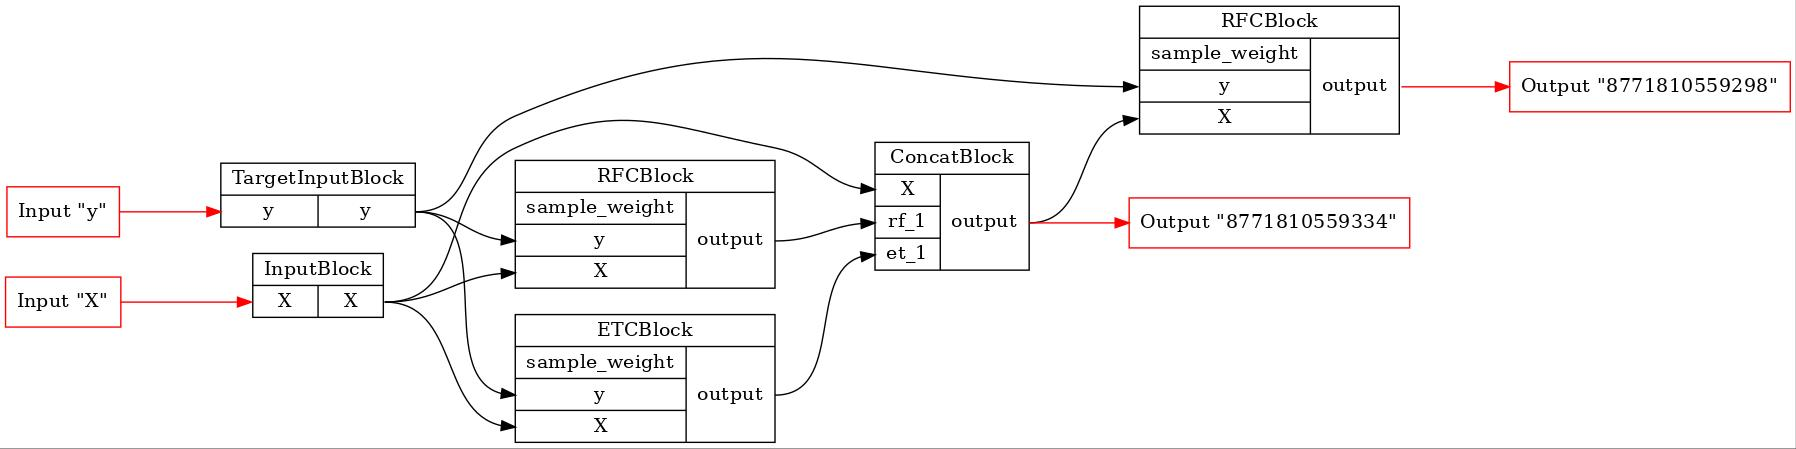

In [7]:
GraphvizPainter(figure_dpi=100).from_pipeline(comparator._common_pipeline).render('pipeline.jpeg')
display(Image('pipeline.jpeg'))

И давайте посмотрим на первый и последний оптимизированные конвейеры стадии FIT.

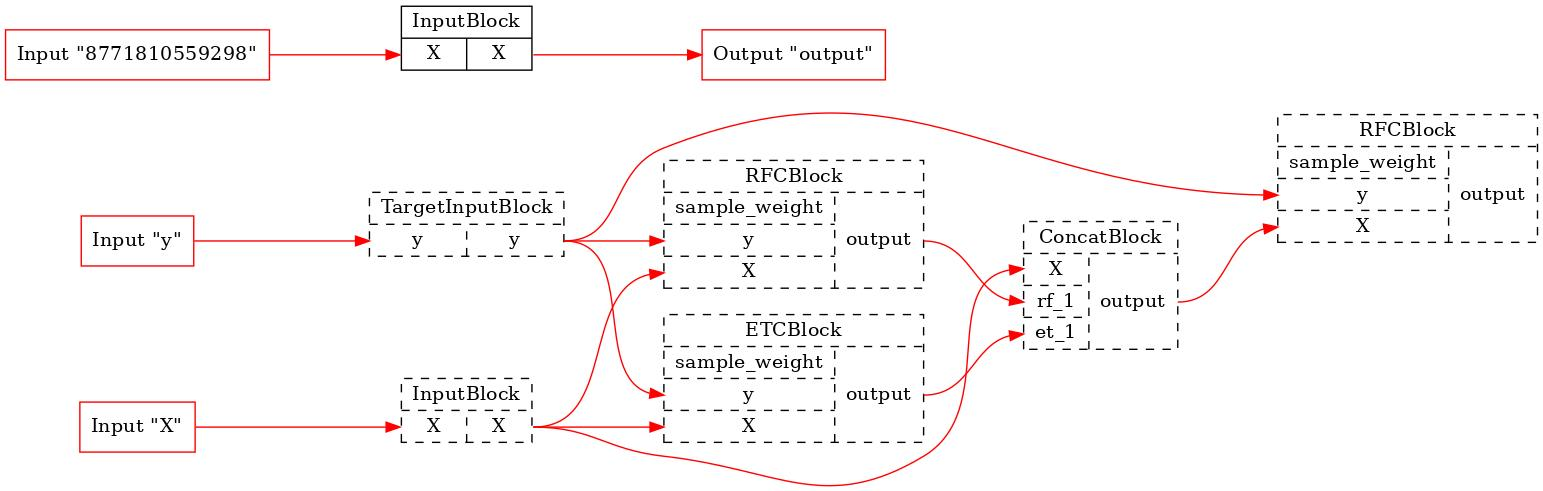

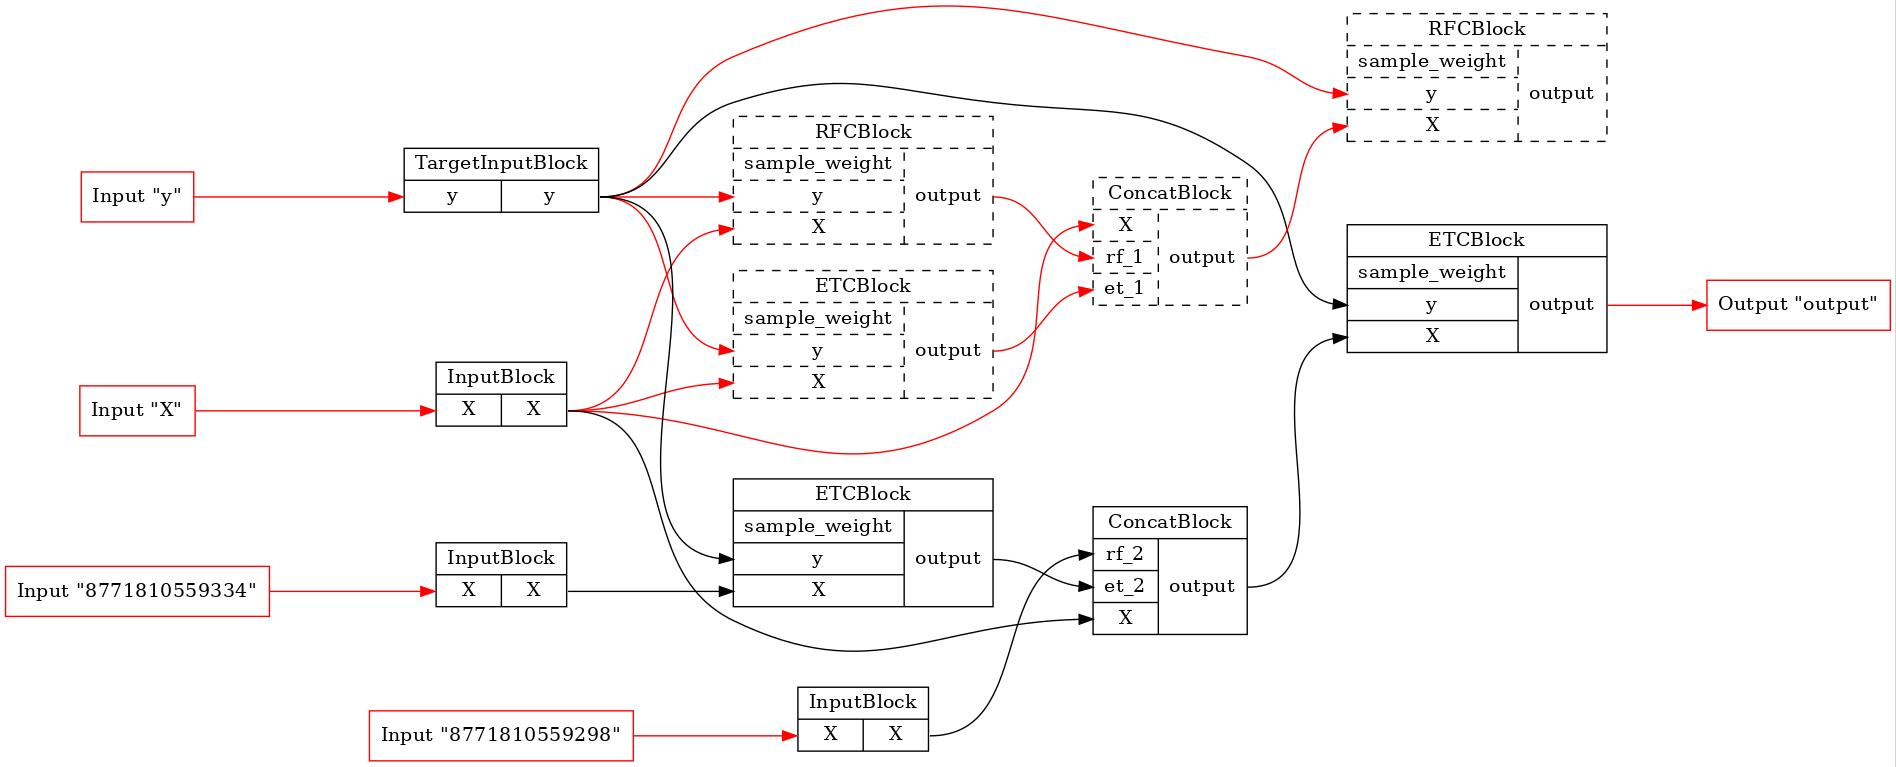

In [8]:
for pip in comparator._optim_pipelines[0::2]:
    executor = TopologicalExecutor(pip, Stage.FIT)
    TopologicalPainter(figure_dpi=100).from_executor(executor).render('pipeline.jpeg')
    display(Image('pipeline.jpeg'))

Как мы видим, ни один из исходных блоков не будет выполняться в первом конвейере. В последнем из тренировочного процесса было исключено множество блоков. Итак, `BaseComparator` находит общую часть конвейеров, вырезает ее из них и вставляет дополнительные входные заглушки. Это позволяет нам запустить общую часть только один раз и использовать ее результаты выполнения в других конвейерах.

Запустим компаратор и получим таблицу результатов

In [9]:
# создадим данные
x, y = make_moons(200, noise=0.5, random_state=random_seed)
data = {'X': CPUData(x), 'y': CPUData(y)}
result = comparator.get_score(data, [
    MetricWrapper(accuracy, name='accuracy'),
    MetricWrapper(roc_auc, name='roc-auc')
])
result.head()

,model name,fold #,train/test,time,blocks time,accuracy,roc-auc
0,deep forest 0,0,train,0.048471,"{InputBlock: 2.19999999995224e-06, TargetInput...",0.992481,0.992857
1,deep forest 0,0,test,0.004177,"{InputBlock: 1.2000000007006406e-06, RFCBlock:...",0.776119,0.772072
2,deep forest 1,0,train,0.048540,"{StackBlock: 2.3399999999895726e-05, AverageBl...",0.992481,0.992857
3,deep forest 1,0,test,0.004222,"{StackBlock: 1.3000000000040757e-05, AverageBl...",0.776119,0.772072
4,deep forest 2,0,train,0.072807,"{TargetInputBlock: 1.3000000000928935e-06, Inp...",1.000000,1.000000


Мы получили Pandas Dataframe. Опишем все столбцы:
- `model name` - название сравниваемой модели. В случае конвейера bosk он будет помечен как `deep forest i`, чужие модели будут называться `model i`. Модели упорядочены так, как они были переданы в списке инициализации.
- `fold #` - номер фолда, начинающийся с 0.
- `train/test` - строковая бинарная метка, является ли это результатом обучения или теста.
- `time` - процессорное время обработки фолда.
- `blocks time` - необязательный столбец, если флаг инициализации `get_blocks_times` был установлен в True. Это единственный столбец, содержащий нескалярные данные. Ячейки содержат словари с блоками конвейера в качестве ключей и их процессорным временем выполнения в качестве значений.
- столбцы `metric_name` - значение соответствующей метрики на этом фолде. Если название метрики не указано, столбец будет называться `metric_i`, где `i` — позиция в списке инициализации.